In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

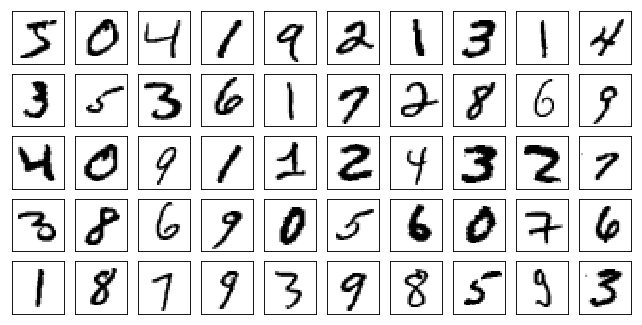

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)    
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [6]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [7]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [8]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [20]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.327425 1: 2.340549 2: 2.296613 3: 2.290284
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.528703 1: 0.646311 2: 0.522253 3: 0.682473
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.300755 1: 0.297055 2: 0.292518 3: 0.301515
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.491225 1: 0.382450 2: 0.479021 3: 0.388505
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.388524 1: 0.344619 2: 0.382316 3: 0.344652
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.210931 1: 0.185536 2: 0.231152 3: 0.204111
Test set:
0: Loss: 0.2578	Accuracy: 9232/10000 (92%)
1: Loss: 0.1998	Accuracy: 9418/10000 (94%)
2: Loss: 0.2527	Accuracy: 9243/10000 (92%)
3: Loss: 0.2102	Accuracy: 9383/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.446509 1: 0.342857 2: 0.428970 3: 0.378852
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.185910 1: 0.140166 2: 0.172756 3: 0.162060
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.229983 1: 0.189725 2: 0.207024 3: 0.226461
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.075219 1: 0.045865 2: 0.056565 3: 0.055696
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.082602 1: 0.057633 2: 0.064620 3: 0.040889
Test set:
0: Loss: 0.0919	Accuracy: 9732/10000 (97%)
1: Loss: 0.0803	Accuracy: 9795/10000 (97%)
2: Loss: 0.0849	Accuracy: 9761/10000 (97%)
3: Loss: 0.0788	Accuracy: 9784/10000 (97%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.049020 1: 0.014964 2: 0.047294 3: 0.018037
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.042093 1: 0.008380 2: 0.030662 3: 0.009727
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.012305 1: 0.002360 2: 0.006216 3: 0.011906
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.069471 1: 0.018460 2: 0.056218 3: 0.009554
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.011594 1: 0.068560 2: 0.008868 3: 0.022940
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.006807 1: 0.000464 2: 0.002929 3: 0.001421
Test set:
0: Loss: 0.0870	Accuracy: 9753/10000 (97%)
1: Loss: 0.0856	Accuracy: 9779/10000 (9

In [21]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

In [22]:
torch.save(models[3], './model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Вывод результатов

In [8]:
model = torch.load('./model_classifier')

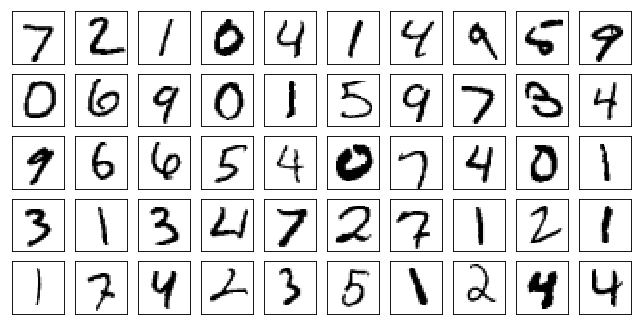

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [9]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

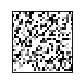

In [13]:
data, _ = next(iter(test_loader))
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [14]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)       
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    
    loss_stats = []    
    lr=1e-2

    for i in range(1, 10000001):  
                
        out = model.forward(gen_img_par)      
                 
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)    
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target) 
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1


        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par, loss_stats      


Iteration 5000: loss=7.706502103133062e-12 prediction=3 lr=0.01
Iteration 10000: loss=3.93796106834543e-12 prediction=3 lr=0.01
Iteration 15000: loss=2.6560975641132245e-12 prediction=3 lr=0.01
Iteration 20000: loss=2.007505273127208e-12 prediction=3 lr=0.01
Iteration 25000: loss=1.6147083670148277e-12 prediction=3 lr=0.01
Iteration 30000: loss=1.3533618670180658e-12 prediction=3 lr=0.01
Iteration 35000: loss=1.1659562204613394e-12 prediction=3 lr=0.01
Iteration 40000: loss=1.0238476733093194e-12 prediction=3 lr=0.01
Iteration 45000: loss=9.126033262418787e-13 prediction=3 lr=0.01
Iteration 50000: loss=8.22897305852166e-13 prediction=3 lr=0.01


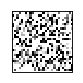

Iteration 55000: loss=7.500666754367558e-13 prediction=3 lr=0.01
Iteration 60000: loss=6.883382752675971e-13 prediction=3 lr=0.01
Iteration 65000: loss=6.363798377151397e-13 prediction=3 lr=0.01
Iteration 70000: loss=5.919709167301335e-13 prediction=3 lr=0.01
Iteration 75000: loss=5.53113110868253e-13 prediction=3 lr=0.01
Iteration 80000: loss=5.182521078950231e-13 prediction=3 lr=0.01
Iteration 85000: loss=4.880540416252188e-13 prediction=3 lr=0.01
Iteration 90000: loss=4.618527782440651e-13 prediction=3 lr=0.01
Iteration 95000: loss=4.3787196091216174e-13 prediction=3 lr=0.01
Iteration 100000: loss=4.1677772344428377e-13 prediction=3 lr=0.01


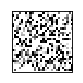

Iteration 105000: loss=3.9768188742073107e-13 prediction=3 lr=0.01
Iteration 110000: loss=3.7991831902672857e-13 prediction=3 lr=0.01
Iteration 115000: loss=3.6415315207705135e-13 prediction=3 lr=0.01
Iteration 120000: loss=3.494982081519993e-13 prediction=3 lr=0.01
Iteration 125000: loss=3.361755318564974e-13 prediction=3 lr=0.01
Iteration 130000: loss=3.2374103398069565e-13 prediction=3 lr=0.01
Iteration 135000: loss=3.1241675912951905e-13 prediction=3 lr=0.01
Iteration 140000: loss=3.015365734881925e-13 prediction=3 lr=0.01
Iteration 145000: loss=2.9176661087149114e-13 prediction=3 lr=0.01
Iteration 150000: loss=2.824407374646398e-13 prediction=3 lr=0.01


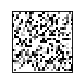

Iteration 155000: loss=2.737809978725636e-13 prediction=3 lr=0.01
Iteration 160000: loss=2.6623148130511254e-13 prediction=3 lr=0.01
Iteration 165000: loss=2.589040093425865e-13 prediction=3 lr=0.01
Iteration 170000: loss=2.5224267119483557e-13 prediction=3 lr=0.01
Iteration 175000: loss=2.4558133304708463e-13 prediction=3 lr=0.01
Iteration 180000: loss=2.395861287141088e-13 prediction=3 lr=0.01
Iteration 185000: loss=2.3359092438113294e-13 prediction=3 lr=0.01
Iteration 190000: loss=2.2803980925800715e-13 prediction=3 lr=0.01
Iteration 195000: loss=2.2248869413488137e-13 prediction=3 lr=0.01
Iteration 200000: loss=2.1782575743145571e-13 prediction=3 lr=0.01


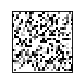

Iteration 205000: loss=2.1316282072803006e-13 prediction=3 lr=0.01
Iteration 210000: loss=2.0827783941967937e-13 prediction=3 lr=0.01
Iteration 215000: loss=2.0405899192610377e-13 prediction=3 lr=0.01
Iteration 220000: loss=2.000621890374532e-13 prediction=3 lr=0.01
Iteration 225000: loss=1.9562129693895258e-13 prediction=3 lr=0.01
Iteration 230000: loss=1.9206858326015208e-13 prediction=3 lr=0.01
Iteration 235000: loss=1.8829382497642655e-13 prediction=3 lr=0.01
Iteration 240000: loss=1.8496315590255108e-13 prediction=3 lr=0.01
Iteration 245000: loss=1.8141044222375058e-13 prediction=3 lr=0.01
Iteration 250000: loss=1.7830181775480014e-13 prediction=3 lr=0.01


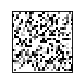

Iteration 255000: loss=1.751931932858497e-13 prediction=3 lr=0.01
Iteration 260000: loss=1.7252865802674933e-13 prediction=3 lr=0.01
Iteration 265000: loss=1.6964207816272392e-13 prediction=3 lr=0.01
Iteration 270000: loss=1.667554982986985e-13 prediction=3 lr=0.01
Iteration 275000: loss=1.6409096303959814e-13 prediction=3 lr=0.01
Iteration 280000: loss=1.616484723854228e-13 prediction=3 lr=0.01
Iteration 285000: loss=1.5942802633617248e-13 prediction=3 lr=0.01
Iteration 290000: loss=1.5698553568199713e-13 prediction=3 lr=0.01
Iteration 295000: loss=1.5432100042289676e-13 prediction=3 lr=0.01
Iteration 300000: loss=1.525446435834965e-13 prediction=3 lr=0.01


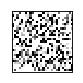

Iteration 305000: loss=1.503241975342462e-13 prediction=3 lr=0.01
Iteration 310000: loss=1.4810375148499588e-13 prediction=3 lr=0.01
Iteration 315000: loss=1.4632739464559563e-13 prediction=3 lr=0.01
Iteration 320000: loss=1.4432899320127035e-13 prediction=3 lr=0.01
Iteration 325000: loss=1.4277468096679513e-13 prediction=3 lr=0.01
Iteration 330000: loss=1.4055423491754482e-13 prediction=3 lr=0.01
Iteration 335000: loss=1.3855583347321954e-13 prediction=3 lr=0.01
Iteration 340000: loss=1.3700152123874432e-13 prediction=3 lr=0.01
Iteration 345000: loss=1.3522516439934407e-13 prediction=3 lr=0.01
Iteration 350000: loss=1.3367085216486885e-13 prediction=3 lr=0.01


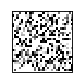

Iteration 355000: loss=1.3211653993039363e-13 prediction=3 lr=0.01
Iteration 360000: loss=1.3078427230084344e-13 prediction=3 lr=0.01
Iteration 365000: loss=1.2945200467129325e-13 prediction=3 lr=0.01
Iteration 370000: loss=1.2811973704174306e-13 prediction=3 lr=0.01
Iteration 375000: loss=1.2678746941219288e-13 prediction=3 lr=0.01
Iteration 380000: loss=1.2523315717771766e-13 prediction=3 lr=0.01
Iteration 385000: loss=1.241229341530925e-13 prediction=3 lr=0.01
Iteration 390000: loss=1.2301271112846734e-13 prediction=3 lr=0.01
Iteration 395000: loss=1.2168044349891716e-13 prediction=3 lr=0.01
Iteration 400000: loss=1.2079226507921703e-13 prediction=3 lr=0.01


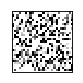

Iteration 405000: loss=1.1968204205459188e-13 prediction=3 lr=0.01
Iteration 410000: loss=1.1857181902996672e-13 prediction=3 lr=0.01
Iteration 415000: loss=1.1746159600534156e-13 prediction=3 lr=0.01
Iteration 420000: loss=1.1657341758564144e-13 prediction=3 lr=0.01
Iteration 425000: loss=1.1524114995609125e-13 prediction=3 lr=0.01
Iteration 430000: loss=1.1457501614131615e-13 prediction=3 lr=0.01
Iteration 435000: loss=1.1368683772161603e-13 prediction=3 lr=0.01
Iteration 440000: loss=1.1257661469699087e-13 prediction=3 lr=0.01
Iteration 445000: loss=1.1146639167236572e-13 prediction=3 lr=0.01
Iteration 450000: loss=1.1057821325266559e-13 prediction=3 lr=0.01


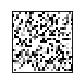

Iteration 455000: loss=1.099120794378905e-13 prediction=3 lr=0.01
Iteration 460000: loss=1.0902390101819037e-13 prediction=3 lr=0.01
Iteration 465000: loss=1.0813572259849025e-13 prediction=3 lr=0.01
Iteration 470000: loss=1.0724754417879012e-13 prediction=3 lr=0.01
Iteration 475000: loss=1.0635936575909e-13 prediction=3 lr=0.01
Iteration 480000: loss=1.0547118733938987e-13 prediction=3 lr=0.01
Iteration 485000: loss=1.0502709812953981e-13 prediction=3 lr=0.01
Iteration 490000: loss=1.0436096431476471e-13 prediction=3 lr=0.01
Iteration 495000: loss=1.0325074129013956e-13 prediction=3 lr=0.01
Iteration 500000: loss=1.028066520802895e-13 prediction=3 lr=0.01


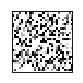

Iteration 505000: loss=1.021405182655144e-13 prediction=3 lr=0.01
Iteration 510000: loss=1.0147438445073931e-13 prediction=3 lr=0.01
Iteration 515000: loss=1.0080825063596421e-13 prediction=3 lr=0.01
Iteration 520000: loss=1.0014211682118912e-13 prediction=3 lr=0.01
Iteration 525000: loss=9.947598300641403e-14 prediction=3 lr=0.01
Iteration 530000: loss=9.880984919163893e-14 prediction=3 lr=0.01
Iteration 535000: loss=9.836575998178887e-14 prediction=3 lr=0.01
Iteration 540000: loss=9.769962616701378e-14 prediction=3 lr=0.01
Iteration 545000: loss=9.703349235223868e-14 prediction=3 lr=0.01
Iteration 550000: loss=9.614531393253856e-14 prediction=3 lr=0.01


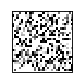

Iteration 555000: loss=9.57012247226885e-14 prediction=3 lr=0.01
Iteration 560000: loss=9.525713551283843e-14 prediction=3 lr=0.01
Iteration 565000: loss=9.50350909079134e-14 prediction=3 lr=0.01
Iteration 570000: loss=9.414691248821327e-14 prediction=3 lr=0.01
Iteration 575000: loss=9.370282327836321e-14 prediction=3 lr=0.01
Iteration 580000: loss=9.325873406851315e-14 prediction=3 lr=0.01
Iteration 585000: loss=9.281464485866309e-14 prediction=3 lr=0.01
Iteration 590000: loss=9.259260025373806e-14 prediction=3 lr=0.01
Iteration 595000: loss=9.192646643896296e-14 prediction=3 lr=0.01
Iteration 600000: loss=9.126033262418787e-14 prediction=3 lr=0.01


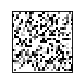

Iteration 605000: loss=9.08162434143378e-14 prediction=3 lr=0.01
Iteration 610000: loss=9.059419880941277e-14 prediction=3 lr=0.01
Iteration 615000: loss=9.015010959956271e-14 prediction=3 lr=0.01
Iteration 620000: loss=8.970602038971265e-14 prediction=3 lr=0.01
Iteration 625000: loss=8.926193117986259e-14 prediction=3 lr=0.01
Iteration 630000: loss=8.881784197001252e-14 prediction=3 lr=0.01
Iteration 635000: loss=8.837375276016246e-14 prediction=3 lr=0.01
Iteration 640000: loss=8.79296635503124e-14 prediction=3 lr=0.01
Iteration 645000: loss=8.770761894538737e-14 prediction=3 lr=0.01
Iteration 650000: loss=8.704148513061227e-14 prediction=3 lr=0.01


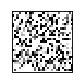

Iteration 655000: loss=8.681944052568724e-14 prediction=3 lr=0.01
Iteration 660000: loss=8.659739592076221e-14 prediction=3 lr=0.01
Iteration 665000: loss=8.615330671091215e-14 prediction=3 lr=0.01
Iteration 670000: loss=8.593126210598712e-14 prediction=3 lr=0.01
Iteration 675000: loss=8.526512829121202e-14 prediction=3 lr=0.01
Iteration 680000: loss=8.482103908136196e-14 prediction=3 lr=0.01
Iteration 685000: loss=8.459899447643693e-14 prediction=3 lr=0.01
Iteration 690000: loss=8.415490526658687e-14 prediction=3 lr=0.01
Iteration 695000: loss=8.393286066166183e-14 prediction=3 lr=0.01
Iteration 700000: loss=8.348877145181177e-14 prediction=3 lr=0.01


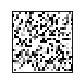

Iteration 705000: loss=8.326672684688674e-14 prediction=3 lr=0.01
Iteration 710000: loss=8.282263763703668e-14 prediction=3 lr=0.01
Iteration 715000: loss=8.215650382226158e-14 prediction=3 lr=0.01
Iteration 720000: loss=8.193445921733655e-14 prediction=3 lr=0.01
Iteration 725000: loss=8.171241461241152e-14 prediction=3 lr=0.01
Iteration 730000: loss=8.126832540256146e-14 prediction=3 lr=0.01
Iteration 735000: loss=8.08242361927114e-14 prediction=3 lr=0.01
Iteration 740000: loss=8.060219158778636e-14 prediction=3 lr=0.01
Iteration 745000: loss=8.01581023779363e-14 prediction=3 lr=0.01
Iteration 750000: loss=7.993605777301127e-14 prediction=3 lr=0.01


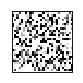

Iteration 755000: loss=7.949196856316121e-14 prediction=3 lr=0.01
Iteration 760000: loss=7.904787935331115e-14 prediction=3 lr=0.01
Iteration 765000: loss=7.882583474838611e-14 prediction=3 lr=0.01
Iteration 770000: loss=7.860379014346108e-14 prediction=3 lr=0.01
Iteration 775000: loss=7.838174553853605e-14 prediction=3 lr=0.01
Iteration 780000: loss=7.793765632868599e-14 prediction=3 lr=0.01
Iteration 785000: loss=7.749356711883593e-14 prediction=3 lr=0.01
Iteration 790000: loss=7.72715225139109e-14 prediction=3 lr=0.01
Iteration 795000: loss=7.704947790898586e-14 prediction=3 lr=0.01
Iteration 800000: loss=7.682743330406083e-14 prediction=3 lr=0.01


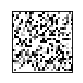

Iteration 805000: loss=7.66053886991358e-14 prediction=3 lr=0.01
Iteration 810000: loss=7.616129948928574e-14 prediction=3 lr=0.01
Iteration 815000: loss=7.593925488436071e-14 prediction=3 lr=0.01
Iteration 820000: loss=7.571721027943568e-14 prediction=3 lr=0.01
Iteration 825000: loss=7.527312106958561e-14 prediction=3 lr=0.01
Iteration 830000: loss=7.505107646466058e-14 prediction=3 lr=0.01
Iteration 835000: loss=7.482903185973555e-14 prediction=3 lr=0.01
Iteration 840000: loss=7.460698725481052e-14 prediction=3 lr=0.01
Iteration 845000: loss=7.438494264988549e-14 prediction=3 lr=0.01
Iteration 850000: loss=7.416289804496046e-14 prediction=3 lr=0.01


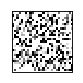

Iteration 855000: loss=7.394085344003543e-14 prediction=3 lr=0.01
Iteration 860000: loss=7.37188088351104e-14 prediction=3 lr=0.01
Iteration 865000: loss=7.30526750203353e-14 prediction=3 lr=0.01
Iteration 870000: loss=7.283063041541027e-14 prediction=3 lr=0.01
Iteration 875000: loss=7.260858581048524e-14 prediction=3 lr=0.01
Iteration 880000: loss=7.238654120556021e-14 prediction=3 lr=0.01
Iteration 885000: loss=7.216449660063518e-14 prediction=3 lr=0.01
Iteration 890000: loss=7.194245199571014e-14 prediction=3 lr=0.01
Iteration 895000: loss=7.172040739078511e-14 prediction=3 lr=0.01
Iteration 900000: loss=7.149836278586008e-14 prediction=3 lr=0.01


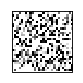

Iteration 905000: loss=7.127631818093505e-14 prediction=3 lr=0.01
Iteration 910000: loss=7.105427357601002e-14 prediction=3 lr=0.01
Iteration 915000: loss=7.061018436615996e-14 prediction=3 lr=0.01
Iteration 920000: loss=7.038813976123492e-14 prediction=3 lr=0.01
Iteration 925000: loss=6.994405055138486e-14 prediction=3 lr=0.01
Iteration 930000: loss=6.972200594645983e-14 prediction=3 lr=0.01
Iteration 935000: loss=6.972200594645983e-14 prediction=3 lr=0.01
Iteration 940000: loss=6.94999613415348e-14 prediction=3 lr=0.01
Iteration 945000: loss=6.927791673660977e-14 prediction=3 lr=0.01
Iteration 950000: loss=6.905587213168474e-14 prediction=3 lr=0.01


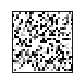

Iteration 955000: loss=6.88338275267597e-14 prediction=3 lr=0.01
Iteration 960000: loss=6.861178292183467e-14 prediction=3 lr=0.01
Iteration 965000: loss=6.816769371198461e-14 prediction=3 lr=0.01
Iteration 970000: loss=6.816769371198461e-14 prediction=3 lr=0.01
Iteration 975000: loss=6.794564910705958e-14 prediction=3 lr=0.01
Iteration 980000: loss=6.772360450213455e-14 prediction=3 lr=0.01
Iteration 985000: loss=6.750155989720952e-14 prediction=3 lr=0.01
Iteration 990000: loss=6.705747068735946e-14 prediction=3 lr=0.01
Iteration 995000: loss=6.705747068735946e-14 prediction=3 lr=0.01
Iteration 1000000: loss=6.683542608243442e-14 prediction=3 lr=0.01


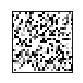

Iteration 1005000: loss=6.661338147750939e-14 prediction=3 lr=0.01
Iteration 1010000: loss=6.639133687258436e-14 prediction=3 lr=0.01
Iteration 1015000: loss=6.616929226765933e-14 prediction=3 lr=0.01
Iteration 1020000: loss=6.59472476627343e-14 prediction=3 lr=0.01
Iteration 1025000: loss=6.550315845288424e-14 prediction=3 lr=0.01
Iteration 1030000: loss=6.52811138479592e-14 prediction=3 lr=0.01
Iteration 1035000: loss=6.505906924303417e-14 prediction=3 lr=0.01
Iteration 1040000: loss=6.505906924303417e-14 prediction=3 lr=0.01
Iteration 1045000: loss=6.483702463810914e-14 prediction=3 lr=0.01
Iteration 1050000: loss=6.461498003318411e-14 prediction=3 lr=0.01


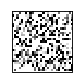

Iteration 1055000: loss=6.461498003318411e-14 prediction=3 lr=0.01
Iteration 1060000: loss=6.439293542825908e-14 prediction=3 lr=0.01
Iteration 1065000: loss=6.394884621840902e-14 prediction=3 lr=0.01
Iteration 1070000: loss=6.372680161348399e-14 prediction=3 lr=0.01
Iteration 1075000: loss=6.372680161348399e-14 prediction=3 lr=0.01
Iteration 1080000: loss=6.328271240363392e-14 prediction=3 lr=0.01
Iteration 1085000: loss=6.306066779870889e-14 prediction=3 lr=0.01
Iteration 1090000: loss=6.306066779870889e-14 prediction=3 lr=0.01
Iteration 1095000: loss=6.283862319378386e-14 prediction=3 lr=0.01
Iteration 1100000: loss=6.261657858885883e-14 prediction=3 lr=0.01


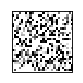

Iteration 1105000: loss=6.261657858885883e-14 prediction=3 lr=0.01
Iteration 1110000: loss=6.23945339839338e-14 prediction=3 lr=0.01
Iteration 1115000: loss=6.217248937900877e-14 prediction=3 lr=0.01
Iteration 1120000: loss=6.217248937900877e-14 prediction=3 lr=0.01
Iteration 1125000: loss=6.195044477408373e-14 prediction=3 lr=0.01
Iteration 1130000: loss=6.17284001691587e-14 prediction=3 lr=0.01
Iteration 1135000: loss=6.17284001691587e-14 prediction=3 lr=0.01
Iteration 1140000: loss=6.150635556423367e-14 prediction=3 lr=0.01
Iteration 1145000: loss=6.106226635438361e-14 prediction=3 lr=0.01
Iteration 1150000: loss=6.084022174945858e-14 prediction=3 lr=0.01


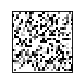

Iteration 1155000: loss=6.061817714453355e-14 prediction=3 lr=0.01
Iteration 1160000: loss=6.061817714453355e-14 prediction=3 lr=0.01
Iteration 1165000: loss=6.039613253960852e-14 prediction=3 lr=0.01
Iteration 1170000: loss=6.017408793468348e-14 prediction=3 lr=0.01
Iteration 1175000: loss=6.017408793468348e-14 prediction=3 lr=0.01
Iteration 1180000: loss=5.995204332975845e-14 prediction=3 lr=0.01
Iteration 1185000: loss=5.995204332975845e-14 prediction=3 lr=0.01
Iteration 1190000: loss=5.972999872483342e-14 prediction=3 lr=0.01
Iteration 1195000: loss=5.950795411990839e-14 prediction=3 lr=0.01
Iteration 1200000: loss=5.950795411990839e-14 prediction=3 lr=0.01


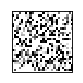

Iteration 1205000: loss=5.928590951498336e-14 prediction=3 lr=0.01
Iteration 1210000: loss=5.928590951498336e-14 prediction=3 lr=0.01
Iteration 1215000: loss=5.88418203051333e-14 prediction=3 lr=0.01
Iteration 1220000: loss=5.88418203051333e-14 prediction=3 lr=0.01
Iteration 1225000: loss=5.861977570020827e-14 prediction=3 lr=0.01
Iteration 1230000: loss=5.861977570020827e-14 prediction=3 lr=0.01
Iteration 1235000: loss=5.839773109528323e-14 prediction=3 lr=0.01
Iteration 1240000: loss=5.839773109528323e-14 prediction=3 lr=0.01
Iteration 1245000: loss=5.795364188543317e-14 prediction=3 lr=0.01
Iteration 1250000: loss=5.773159728050814e-14 prediction=3 lr=0.01


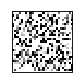

Iteration 1255000: loss=5.773159728050814e-14 prediction=3 lr=0.01
Iteration 1260000: loss=5.750955267558311e-14 prediction=3 lr=0.01
Iteration 1265000: loss=5.750955267558311e-14 prediction=3 lr=0.01
Iteration 1270000: loss=5.728750807065808e-14 prediction=3 lr=0.01
Iteration 1275000: loss=5.728750807065808e-14 prediction=3 lr=0.01
Iteration 1280000: loss=5.706546346573305e-14 prediction=3 lr=0.01
Iteration 1285000: loss=5.706546346573305e-14 prediction=3 lr=0.01
Iteration 1290000: loss=5.684341886080802e-14 prediction=3 lr=0.01
Iteration 1295000: loss=5.684341886080802e-14 prediction=3 lr=0.01
Iteration 1300000: loss=5.639932965095795e-14 prediction=3 lr=0.01


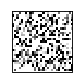

Iteration 1305000: loss=5.639932965095795e-14 prediction=3 lr=0.01
Iteration 1310000: loss=5.639932965095795e-14 prediction=3 lr=0.01
Iteration 1315000: loss=5.617728504603292e-14 prediction=3 lr=0.01
Iteration 1320000: loss=5.617728504603292e-14 prediction=3 lr=0.01
Iteration 1325000: loss=5.595524044110789e-14 prediction=3 lr=0.01
Iteration 1330000: loss=5.595524044110789e-14 prediction=3 lr=0.01
Iteration 1335000: loss=5.573319583618286e-14 prediction=3 lr=0.01
Iteration 1340000: loss=5.573319583618286e-14 prediction=3 lr=0.01
Iteration 1345000: loss=5.551115123125783e-14 prediction=3 lr=0.01
Iteration 1350000: loss=5.551115123125783e-14 prediction=3 lr=0.01


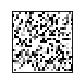

Iteration 1355000: loss=5.551115123125783e-14 prediction=3 lr=0.01
Iteration 1360000: loss=5.5067062021407764e-14 prediction=3 lr=0.01
Iteration 1365000: loss=5.5067062021407764e-14 prediction=3 lr=0.01
Iteration 1370000: loss=5.484501741648273e-14 prediction=3 lr=0.01
Iteration 1375000: loss=5.484501741648273e-14 prediction=3 lr=0.01
Iteration 1380000: loss=5.46229728115577e-14 prediction=3 lr=0.01
Iteration 1385000: loss=5.46229728115577e-14 prediction=3 lr=0.01
Iteration 1390000: loss=5.46229728115577e-14 prediction=3 lr=0.01
Iteration 1395000: loss=5.417888360170764e-14 prediction=3 lr=0.01
Iteration 1400000: loss=5.417888360170764e-14 prediction=3 lr=0.01


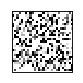

Iteration 1405000: loss=5.395683899678261e-14 prediction=3 lr=0.01
Iteration 1410000: loss=5.395683899678261e-14 prediction=3 lr=0.01
Iteration 1415000: loss=5.3734794391857577e-14 prediction=3 lr=0.01
Iteration 1420000: loss=5.3734794391857577e-14 prediction=3 lr=0.01
Iteration 1425000: loss=5.3734794391857577e-14 prediction=3 lr=0.01
Iteration 1430000: loss=5.3512749786932545e-14 prediction=3 lr=0.01
Iteration 1435000: loss=5.3512749786932545e-14 prediction=3 lr=0.01
Iteration 1440000: loss=5.3290705182007514e-14 prediction=3 lr=0.01
Iteration 1445000: loss=5.3290705182007514e-14 prediction=3 lr=0.01
Iteration 1450000: loss=5.3290705182007514e-14 prediction=3 lr=0.01


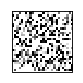

Iteration 1455000: loss=5.306866057708248e-14 prediction=3 lr=0.01
Iteration 1460000: loss=5.306866057708248e-14 prediction=3 lr=0.01
Iteration 1465000: loss=5.284661597215745e-14 prediction=3 lr=0.01
Iteration 1470000: loss=5.284661597215745e-14 prediction=3 lr=0.01
Iteration 1475000: loss=5.284661597215745e-14 prediction=3 lr=0.01
Iteration 1480000: loss=5.262457136723242e-14 prediction=3 lr=0.01
Iteration 1485000: loss=5.262457136723242e-14 prediction=3 lr=0.01
Iteration 1490000: loss=5.218048215738236e-14 prediction=3 lr=0.01
Iteration 1495000: loss=5.218048215738236e-14 prediction=3 lr=0.01
Iteration 1500000: loss=5.1958437552457326e-14 prediction=3 lr=0.01


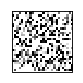

Iteration 1505000: loss=5.1736392947532295e-14 prediction=3 lr=0.01
Iteration 1510000: loss=5.1736392947532295e-14 prediction=3 lr=0.01
Iteration 1515000: loss=5.1736392947532295e-14 prediction=3 lr=0.01
Iteration 1520000: loss=5.1514348342607263e-14 prediction=3 lr=0.01
Iteration 1525000: loss=5.1514348342607263e-14 prediction=3 lr=0.01
Iteration 1530000: loss=5.129230373768223e-14 prediction=3 lr=0.01
Iteration 1535000: loss=5.129230373768223e-14 prediction=3 lr=0.01
Iteration 1540000: loss=5.129230373768223e-14 prediction=3 lr=0.01
Iteration 1545000: loss=5.10702591327572e-14 prediction=3 lr=0.01
Iteration 1550000: loss=5.10702591327572e-14 prediction=3 lr=0.01


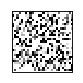

Iteration 1555000: loss=5.10702591327572e-14 prediction=3 lr=0.01
Iteration 1560000: loss=5.084821452783217e-14 prediction=3 lr=0.01
Iteration 1565000: loss=5.084821452783217e-14 prediction=3 lr=0.01
Iteration 1570000: loss=5.084821452783217e-14 prediction=3 lr=0.01
Iteration 1575000: loss=5.062616992290714e-14 prediction=3 lr=0.01
Iteration 1580000: loss=5.062616992290714e-14 prediction=3 lr=0.01
Iteration 1585000: loss=5.062616992290714e-14 prediction=3 lr=0.01
Iteration 1590000: loss=5.040412531798211e-14 prediction=3 lr=0.01
Iteration 1595000: loss=5.040412531798211e-14 prediction=3 lr=0.01
Iteration 1600000: loss=5.040412531798211e-14 prediction=3 lr=0.01


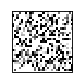

Iteration 1605000: loss=5.0182080713057076e-14 prediction=3 lr=0.01
Iteration 1610000: loss=5.0182080713057076e-14 prediction=3 lr=0.01
Iteration 1615000: loss=4.9960036108132044e-14 prediction=3 lr=0.01
Iteration 1620000: loss=4.973799150320701e-14 prediction=3 lr=0.01
Iteration 1625000: loss=4.973799150320701e-14 prediction=3 lr=0.01
Iteration 1630000: loss=4.973799150320701e-14 prediction=3 lr=0.01
Iteration 1635000: loss=4.951594689828198e-14 prediction=3 lr=0.01
Iteration 1640000: loss=4.951594689828198e-14 prediction=3 lr=0.01
Iteration 1645000: loss=4.929390229335695e-14 prediction=3 lr=0.01
Iteration 1650000: loss=4.884981308350689e-14 prediction=3 lr=0.01


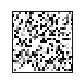

Iteration 1655000: loss=4.884981308350689e-14 prediction=3 lr=0.01
Iteration 1660000: loss=4.884981308350689e-14 prediction=3 lr=0.01
Iteration 1665000: loss=4.8627768478581856e-14 prediction=3 lr=0.01
Iteration 1670000: loss=4.8627768478581856e-14 prediction=3 lr=0.01
Iteration 1675000: loss=4.8627768478581856e-14 prediction=3 lr=0.01
Iteration 1680000: loss=4.8405723873656825e-14 prediction=3 lr=0.01
Iteration 1685000: loss=4.8405723873656825e-14 prediction=3 lr=0.01
Iteration 1690000: loss=4.8405723873656825e-14 prediction=3 lr=0.01
Iteration 1695000: loss=4.8183679268731794e-14 prediction=3 lr=0.01
Iteration 1700000: loss=4.8183679268731794e-14 prediction=3 lr=0.01


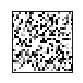

Iteration 1705000: loss=4.8183679268731794e-14 prediction=3 lr=0.01
Iteration 1710000: loss=4.796163466380676e-14 prediction=3 lr=0.01
Iteration 1715000: loss=4.796163466380676e-14 prediction=3 lr=0.01
Iteration 1720000: loss=4.796163466380676e-14 prediction=3 lr=0.01
Iteration 1725000: loss=4.796163466380676e-14 prediction=3 lr=0.01
Iteration 1730000: loss=4.773959005888173e-14 prediction=3 lr=0.01
Iteration 1735000: loss=4.773959005888173e-14 prediction=3 lr=0.01
Iteration 1740000: loss=4.75175454539567e-14 prediction=3 lr=0.01
Iteration 1745000: loss=4.729550084903167e-14 prediction=3 lr=0.01
Iteration 1750000: loss=4.729550084903167e-14 prediction=3 lr=0.01


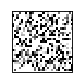

Iteration 1755000: loss=4.729550084903167e-14 prediction=3 lr=0.01
Iteration 1760000: loss=4.729550084903167e-14 prediction=3 lr=0.01
Iteration 1765000: loss=4.707345624410664e-14 prediction=3 lr=0.01
Iteration 1770000: loss=4.707345624410664e-14 prediction=3 lr=0.01
Iteration 1775000: loss=4.707345624410664e-14 prediction=3 lr=0.01
Iteration 1780000: loss=4.6851411639181606e-14 prediction=3 lr=0.01
Iteration 1785000: loss=4.6851411639181606e-14 prediction=3 lr=0.01
Iteration 1790000: loss=4.6851411639181606e-14 prediction=3 lr=0.01
Iteration 1795000: loss=4.6851411639181606e-14 prediction=3 lr=0.01
Iteration 1800000: loss=4.6629367034256575e-14 prediction=3 lr=0.01


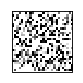

Iteration 1805000: loss=4.6629367034256575e-14 prediction=3 lr=0.01
Iteration 1810000: loss=4.6629367034256575e-14 prediction=3 lr=0.01
Iteration 1815000: loss=4.618527782440651e-14 prediction=3 lr=0.01
Iteration 1820000: loss=4.618527782440651e-14 prediction=3 lr=0.01
Iteration 1825000: loss=4.618527782440651e-14 prediction=3 lr=0.01
Iteration 1830000: loss=4.618527782440651e-14 prediction=3 lr=0.01
Iteration 1835000: loss=4.596323321948148e-14 prediction=3 lr=0.01
Iteration 1840000: loss=4.596323321948148e-14 prediction=3 lr=0.01
Iteration 1845000: loss=4.596323321948148e-14 prediction=3 lr=0.01
Iteration 1850000: loss=4.596323321948148e-14 prediction=3 lr=0.01


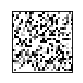

Iteration 1855000: loss=4.574118861455645e-14 prediction=3 lr=0.01
Iteration 1860000: loss=4.574118861455645e-14 prediction=3 lr=0.01
Iteration 1865000: loss=4.574118861455645e-14 prediction=3 lr=0.01
Iteration 1870000: loss=4.574118861455645e-14 prediction=3 lr=0.01
Iteration 1875000: loss=4.551914400963142e-14 prediction=3 lr=0.01
Iteration 1880000: loss=4.551914400963142e-14 prediction=3 lr=0.01
Iteration 1885000: loss=4.529709940470639e-14 prediction=3 lr=0.01
Iteration 1890000: loss=4.5075054799781356e-14 prediction=3 lr=0.01
Iteration 1895000: loss=4.5075054799781356e-14 prediction=3 lr=0.01
Iteration 1900000: loss=4.5075054799781356e-14 prediction=3 lr=0.01


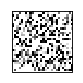

Iteration 1905000: loss=4.5075054799781356e-14 prediction=3 lr=0.01
Iteration 1910000: loss=4.4853010194856324e-14 prediction=3 lr=0.01
Iteration 1915000: loss=4.4853010194856324e-14 prediction=3 lr=0.01
Iteration 1920000: loss=4.4853010194856324e-14 prediction=3 lr=0.01
Iteration 1925000: loss=4.4853010194856324e-14 prediction=3 lr=0.01
Iteration 1930000: loss=4.463096558993129e-14 prediction=3 lr=0.01
Iteration 1935000: loss=4.463096558993129e-14 prediction=3 lr=0.01
Iteration 1940000: loss=4.463096558993129e-14 prediction=3 lr=0.01
Iteration 1945000: loss=4.463096558993129e-14 prediction=3 lr=0.01
Iteration 1950000: loss=4.440892098500626e-14 prediction=3 lr=0.01


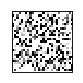

Iteration 1955000: loss=4.440892098500626e-14 prediction=3 lr=0.01
Iteration 1960000: loss=4.440892098500626e-14 prediction=3 lr=0.01
Iteration 1965000: loss=4.440892098500626e-14 prediction=3 lr=0.01
Iteration 1970000: loss=4.440892098500626e-14 prediction=3 lr=0.01
Iteration 1975000: loss=4.418687638008123e-14 prediction=3 lr=0.01
Iteration 1980000: loss=4.418687638008123e-14 prediction=3 lr=0.01
Iteration 1985000: loss=4.418687638008123e-14 prediction=3 lr=0.01
Iteration 1990000: loss=4.418687638008123e-14 prediction=3 lr=0.01
Iteration 1995000: loss=4.39648317751562e-14 prediction=3 lr=0.01
Iteration 2000000: loss=4.39648317751562e-14 prediction=3 lr=0.01


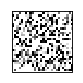

Iteration 2005000: loss=4.39648317751562e-14 prediction=3 lr=0.01
Iteration 2010000: loss=4.39648317751562e-14 prediction=3 lr=0.01
Iteration 2015000: loss=4.39648317751562e-14 prediction=3 lr=0.01
Iteration 2020000: loss=4.374278717023117e-14 prediction=3 lr=0.01
Iteration 2025000: loss=4.374278717023117e-14 prediction=3 lr=0.01
Iteration 2030000: loss=4.3520742565306136e-14 prediction=3 lr=0.01
Iteration 2035000: loss=4.3520742565306136e-14 prediction=3 lr=0.01
Iteration 2040000: loss=4.3298697960381105e-14 prediction=3 lr=0.01
Iteration 2045000: loss=4.3298697960381105e-14 prediction=3 lr=0.01
Iteration 2050000: loss=4.3076653355456074e-14 prediction=3 lr=0.01


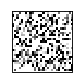

Iteration 2055000: loss=4.3076653355456074e-14 prediction=3 lr=0.01
Iteration 2060000: loss=4.3076653355456074e-14 prediction=3 lr=0.01
Iteration 2065000: loss=4.285460875053104e-14 prediction=3 lr=0.01
Iteration 2070000: loss=4.285460875053104e-14 prediction=3 lr=0.01
Iteration 2075000: loss=4.285460875053104e-14 prediction=3 lr=0.01
Iteration 2080000: loss=4.285460875053104e-14 prediction=3 lr=0.01
Iteration 2085000: loss=4.285460875053104e-14 prediction=3 lr=0.01
Iteration 2090000: loss=4.263256414560601e-14 prediction=3 lr=0.01
Iteration 2095000: loss=4.263256414560601e-14 prediction=3 lr=0.01
Iteration 2100000: loss=4.263256414560601e-14 prediction=3 lr=0.01


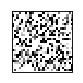

Iteration 2105000: loss=4.263256414560601e-14 prediction=3 lr=0.01
Iteration 2110000: loss=4.241051954068098e-14 prediction=3 lr=0.01
Iteration 2115000: loss=4.241051954068098e-14 prediction=3 lr=0.01
Iteration 2120000: loss=4.241051954068098e-14 prediction=3 lr=0.01
Iteration 2125000: loss=4.241051954068098e-14 prediction=3 lr=0.01
Iteration 2130000: loss=4.241051954068098e-14 prediction=3 lr=0.01
Iteration 2135000: loss=4.218847493575595e-14 prediction=3 lr=0.01
Iteration 2140000: loss=4.218847493575595e-14 prediction=3 lr=0.01
Iteration 2145000: loss=4.218847493575595e-14 prediction=3 lr=0.01
Iteration 2150000: loss=4.218847493575595e-14 prediction=3 lr=0.01


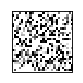

Iteration 2155000: loss=4.218847493575595e-14 prediction=3 lr=0.01
Iteration 2160000: loss=4.196643033083092e-14 prediction=3 lr=0.01
Iteration 2165000: loss=4.196643033083092e-14 prediction=3 lr=0.01
Iteration 2170000: loss=4.196643033083092e-14 prediction=3 lr=0.01
Iteration 2175000: loss=4.196643033083092e-14 prediction=3 lr=0.01
Iteration 2180000: loss=4.196643033083092e-14 prediction=3 lr=0.01
Iteration 2185000: loss=4.1744385725905886e-14 prediction=3 lr=0.01
Iteration 2190000: loss=4.1744385725905886e-14 prediction=3 lr=0.01
Iteration 2195000: loss=4.1744385725905886e-14 prediction=3 lr=0.01
Iteration 2200000: loss=4.1744385725905886e-14 prediction=3 lr=0.01


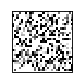

Iteration 2205000: loss=4.1744385725905886e-14 prediction=3 lr=0.01
Iteration 2210000: loss=4.1744385725905886e-14 prediction=3 lr=0.01
Decreasing LR ..
Iteration 2215000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2220000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2225000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2230000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2235000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2240000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2245000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2250000: loss=4.1522341120980855e-14 prediction=3 lr=0.005


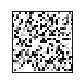

Iteration 2255000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2260000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Iteration 2265000: loss=4.1522341120980855e-14 prediction=3 lr=0.005
Decreasing LR ..
Iteration 2270000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2275000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2280000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2285000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2290000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2295000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2300000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025


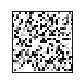

Iteration 2305000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2310000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2315000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Iteration 2320000: loss=4.1522341120980855e-14 prediction=3 lr=0.0025
Decreasing LR ..
Iteration 2325000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2330000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2335000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2340000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2345000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2350000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125


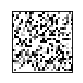

Iteration 2355000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2360000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2365000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2370000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Iteration 2375000: loss=4.1522341120980855e-14 prediction=3 lr=0.00125
Decreasing LR ..
Iteration 2380000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2385000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2390000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2395000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2400000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625


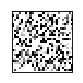

Iteration 2405000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2410000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2415000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2420000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2425000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Iteration 2430000: loss=4.1522341120980855e-14 prediction=3 lr=0.000625
Decreasing LR ..
Iteration 2435000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2440000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2445000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2450000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125


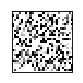

Iteration 2455000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2460000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2465000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2470000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2475000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2480000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Iteration 2485000: loss=4.1522341120980855e-14 prediction=3 lr=0.0003125
Decreasing LR ..
Iteration 2490000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2495000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2500000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625


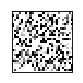

Iteration 2505000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2510000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2515000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2520000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2525000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2530000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2535000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Iteration 2540000: loss=4.1522341120980855e-14 prediction=3 lr=0.00015625
Decreasing LR ..
Iteration 2545000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2550000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05


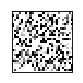

Iteration 2555000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2560000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2565000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2570000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2575000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2580000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2585000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2590000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Iteration 2595000: loss=4.1522341120980855e-14 prediction=3 lr=7.8125e-05
Decreasing LR ..
Iteration 2600000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05


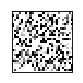

Iteration 2605000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2610000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2615000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2620000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2625000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2630000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2635000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2640000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2645000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Iteration 2650000: loss=4.1522341120980855e-14 prediction=3 lr=3.90625e-05
Decreasing LR ..


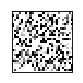

Iteration 2655000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2660000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2665000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2670000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2675000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2680000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2685000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2690000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2695000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Iteration 2700000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05


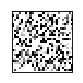

Iteration 2705000: loss=4.1522341120980855e-14 prediction=3 lr=1.953125e-05
Decreasing LR ..
Iteration 2710000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2715000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2720000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2725000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2730000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2735000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2740000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2745000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2750000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06


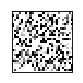

Iteration 2755000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Iteration 2760000: loss=4.1522341120980855e-14 prediction=3 lr=9.765625e-06
Decreasing LR ..
Iteration 2765000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2770000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2775000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2780000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2785000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2790000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2795000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2800000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06


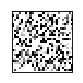

Iteration 2805000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2810000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Iteration 2815000: loss=4.1522341120980855e-14 prediction=3 lr=4.8828125e-06
Decreasing LR ..
Iteration 2820000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2825000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2830000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2835000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2840000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2845000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2850000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06


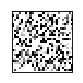

Iteration 2855000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2860000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2865000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Iteration 2870000: loss=4.1522341120980855e-14 prediction=3 lr=2.44140625e-06
Decreasing LR ..
Iteration 2875000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2880000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2885000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2890000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2895000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2900000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06


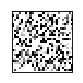

Iteration 2905000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2910000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2915000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2920000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Iteration 2925000: loss=4.1522341120980855e-14 prediction=3 lr=1.220703125e-06
Decreasing LR ..
Stop ..


In [15]:
new_image_randn = generate_image(img, 3)

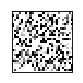

In [17]:
to_plot = new_image_randn[0].view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))

Изображение цифры "3" выглядит очень зашумленным